In [10]:
!wget -O brain_tumor_dataset.zip https://figshare.com/ndownloader/articles/1512427/versions/5

--2023-04-19 10:23:55--  https://figshare.com/ndownloader/articles/1512427/versions/5
Resolving figshare.com (figshare.com)... 34.249.68.44, 52.215.144.107
Connecting to figshare.com (figshare.com)|34.249.68.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: 'brain_tumor_dataset.zip'

     0K .......... .......... .......... .......... ..........  0%  499K 28m41s
    50K .......... .......... .......... .......... ..........  0%  519K 28m8s
   100K .......... .......... .......... .......... ..........  0% 19.6M 19m0s
   150K .......... .......... .......... .......... ..........  0%  536K 20m55s
   200K .......... .......... .......... .......... ..........  0% 16.2M 16m54s
   250K .......... .......... .......... .......... ..........  0%  537K 18m32s
   300K .......... .......... .......... .......... ..........  0% 26.6M 15m57s
   350K .......... .......... .......... .......... ..........  0% 13.5M 14m5s
   40

In [2]:
!pip install opendatasets

     ---------------------------------------- 63.3/63.3 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77731 sha256=daea414e1e06bd68a2c3292af686496fbc3857d8152b361ff657831a9437ca79
  Stored in directory: c:\users\brijv\appdata\local\pip\cache\wheels\1b\22\79\e73b3e988388377c1cda3385bfa20c1799be101c2e12bbe3dc
Successfully built kaggle


In [4]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/sinamhd9/chexnet-weights")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: manojgowda27
Your Kaggle Key: ········


100%|██████████| 25.4M/25.4M [00:01<00:00, 24.2MB/s]


In [11]:
!unzip brain_tumor_dataset.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
!pip install pymatreader

In [19]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from pymatreader import read_mat
import cv2
from sklearn.model_selection import train_test_split
from keras.applications import densenet
from keras.initializers import GlorotNormal

<b> Convolutional Neural Network </b>

In [20]:
class Brain_Tumor:
  def __init__(self, epochs, 
               batch_size, 
               dataset_folder,
               optimizer,
               loss):
    self.epochs = epochs
    self.batch_size = batch_size
    self.dataset_folder = dataset_folder
    self.optimizer = optimizer
    self.loss = loss
    self.DatasetFiles = list(pathlib.Path(os.path.join(self.dataset_folder)).glob("*.*"))
    self.classes = ["meningioma", "glioma","pituitary"]
    
    # Reading mat files
    
  def read_mat_file(self, 
                    single_file):
    return read_mat(os.path.join(single_file))

    # Image Plotting
    
  def plot_some_dataset_images(self,
                               number_of_image):
    plt.figure(figsize = (20, 8))
    for i in range(number_of_image):
      mat_obj = self.read_mat_file(self.DatasetFiles[i])
      plt.subplot(2, 4, i + 1)
      img = mat_obj['cjdata']['image']
      label = int(mat_obj['cjdata']['label'])
      plt.imshow(img)
      plt.title(self.classes[label - 1])
    plt.show()
    
    # Label Retrieval
    
  def collect_features_labels(self):
    images = []
    labels = []
    for single_file in self.DatasetFiles:
      mat_obj = self.read_mat_file(single_file)
      img = mat_obj['cjdata']['image']
      img = img/255
      img = np.float32(img)
      img = cv2.resize(img, (224, 224))
      img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
      img = img - np.mean(img)
      img = img/np.std(img)
      lab = int(mat_obj['cjdata']['label'])
      images.append(img)
      labels.append(lab)
    self.images = np.asarray(images)
    self.labels = np.asarray(labels)
    
    # Data Augmentation
    
  def DataAugmentation_Object(self):
    return tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.2,
        zoom_range=0.01,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=None)

  def augmentated_images(self):
    images_after_aug = []
    labels_after_aug = []
    augmentation_object = self.DataAugmentation_Object()
    for index, image in enumerate(self.images):
      for i in range(3):
          img = augmentation_object.flow(np.reshape(image, (1, 224, 224, 3))).next()
          images_after_aug.append(np.reshape(img, (224, 224, 3)))
          labels_after_aug.append(self.labels[index])
    self.labels = np.asarray(labels_after_aug)
    self.images = np.asarray(images_after_aug)
  def to_categorical_label(self):
    self.labels = self.labels - 1
    self.labels = tf.keras.utils.to_categorical(self.labels, num_classes = 3)
  def train_test_split(self, test_size):
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.images, 
                                                        self.labels, 
                                                        random_state = 42, 
                                                        test_size = test_size)
    # Model Definition
    
  def Model(self):
    d = densenet.DenseNet121(weights=None, include_top = False, input_shape = (224, 224, 3))
    m = tf.keras.layers.Dropout(0.8)(d.output)
    m = tf.keras.layers.GlobalAveragePooling2D(name = "GlobalAveragePooling2D_")(m)                         
    m = tf.keras.layers.Dropout(0.8)(m)
    m = tf.keras.layers.Dense(3, kernel_initializer=GlorotNormal(),
                              activation = 'softmax', kernel_regularizer= tf.keras.regularizers.L2(0.0001),
                              bias_regularizer= tf.keras.regularizers.L2(0.0001))(m)
    m = tf.keras.models.Model(inputs = d.input, outputs = m)
    m.load_weights("chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5", by_name=True, skip_mismatch=True)
    for layer in m.layers[:200]:
        layer.trainable = False
    for layer in m.layers[200:]:
        layer.trainable = True
    self.m = m
    
  def compile(self):
    self.m.compile(optimizer = self.optimizer
          , loss = self.loss, metrics = ['accuracy'])
  def fit_model(self):
    self.history = self.m.fit(self.X_train, self.y_train, epochs = self.epochs, batch_size = self.batch_size,
                validation_data = (self.X_test, self.y_test),
                callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, mode = 'min',
                                                  patience= 2),
                             tf.keras.callbacks.EarlyStopping(patience = 14, monitor = 'val_loss', mode = 'min', restore_best_weights=True)])  

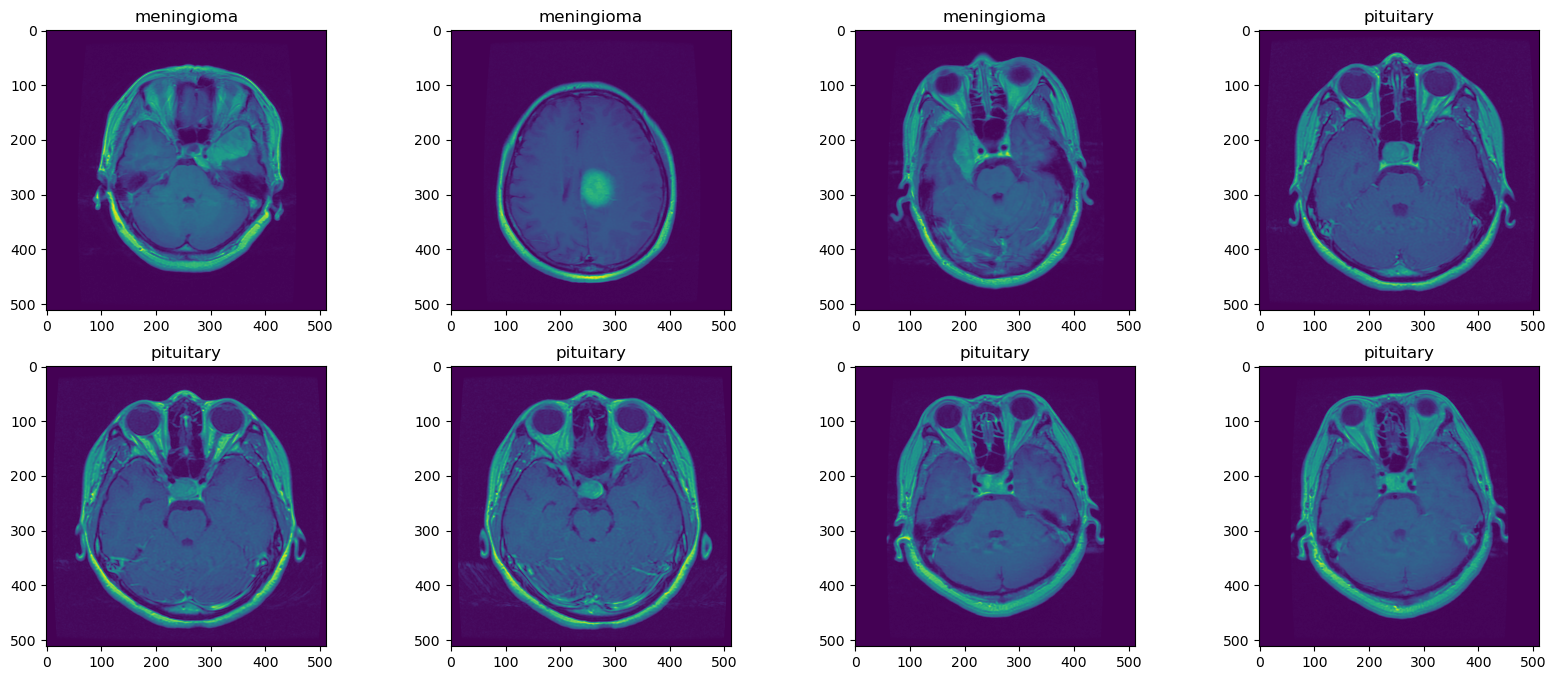

In [25]:
Brain_Tumor_obj = Brain_Tumor(25, 
                              2, 
                              'brain_tumor_dataset', 
                              tf.keras.optimizers.Adam(0.001), 
                              'categorical_crossentropy')
Brain_Tumor_obj.plot_some_dataset_images(8)

In [26]:
Brain_Tumor_obj.collect_features_labels()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


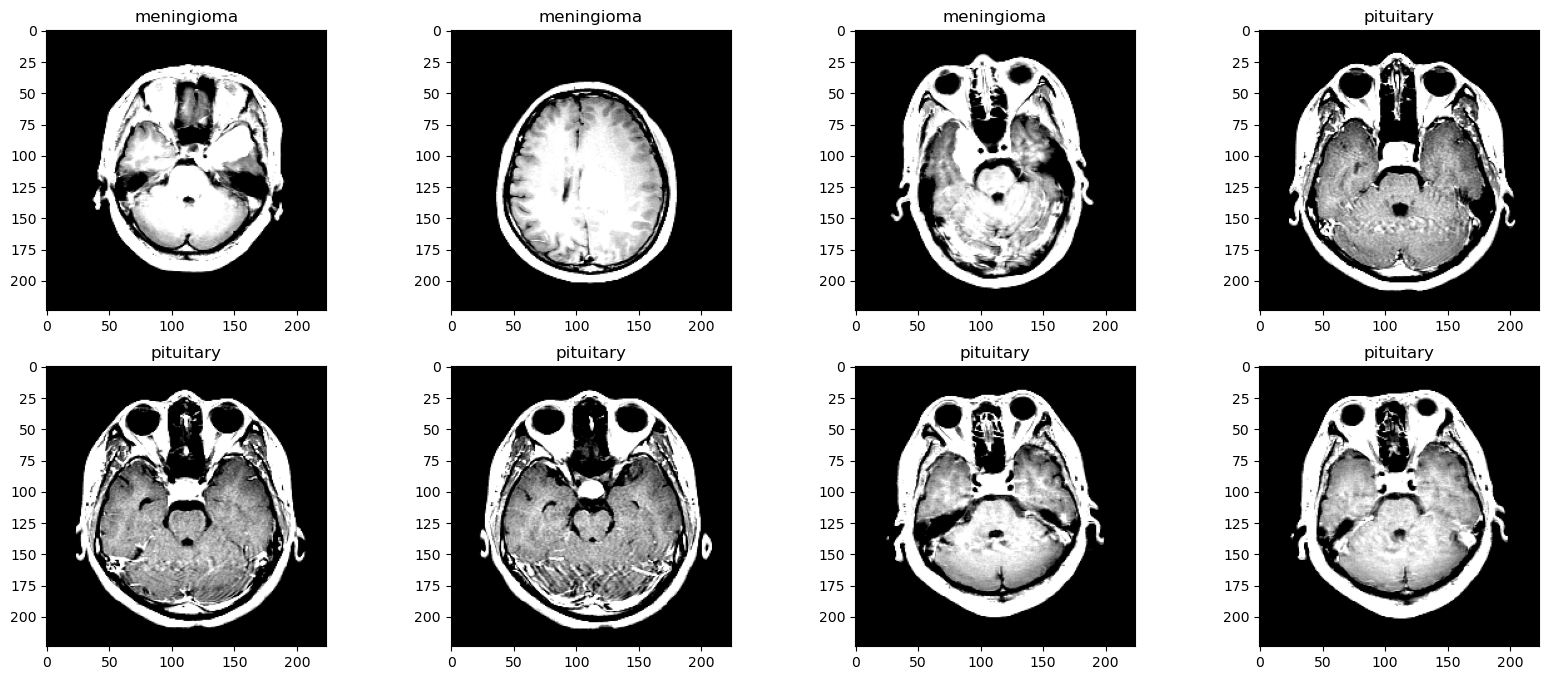

In [29]:
plt.figure(figsize = (20, 8))
for i in range(8):
  plt.subplot(2, 4, i+ 1)
  plt.imshow(Brain_Tumor_obj.images[i])
  plt.title(Brain_Tumor_obj.classes[Brain_Tumor_obj.labels[i] - 1])
plt.show()

In [30]:
Brain_Tumor_obj.augmentated_images()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


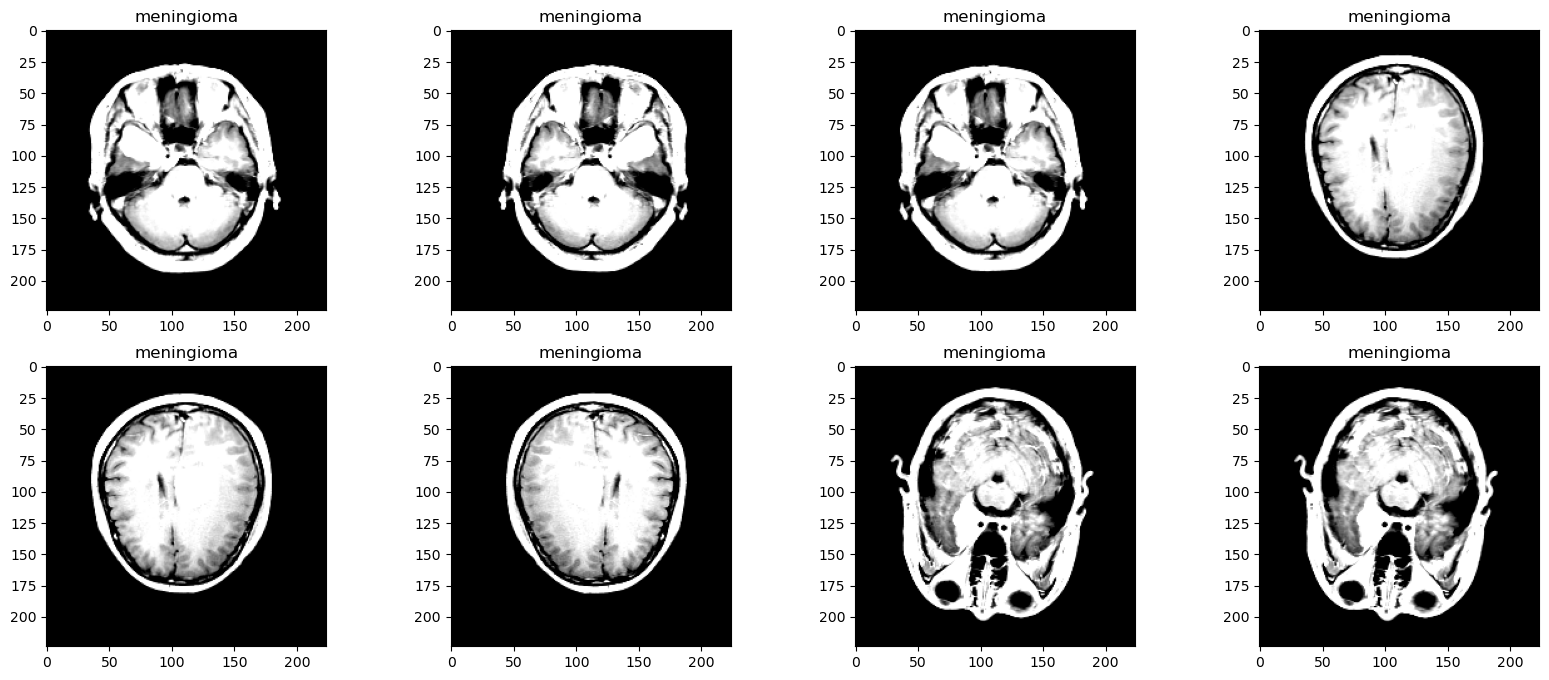

In [31]:
plt.figure(figsize = (20, 8))
for i in range(8):
  plt.subplot(2, 4, i + 1)
  plt.imshow(Brain_Tumor_obj.images[i])
  plt.title(Brain_Tumor_obj.classes[Brain_Tumor_obj.labels[i] - 1])
plt.show()

In [32]:
Brain_Tumor_obj.to_categorical_label()

In [33]:
Brain_Tumor_obj.train_test_split(0.1)

In [34]:
Brain_Tumor_obj.Model()
Brain_Tumor_obj.compile()
Brain_Tumor_obj.fit_model()

Epoch 1/25
4136/4136 [==============================] - 960s 229ms/step - loss: 0.8864 - accuracy: 0.6319 - val_loss: 0.3882 - val_accuracy: 0.8467 - lr: 0.0010
Epoch 2/25
4136/4136 [==============================] - 964s 233ms/step - loss: 0.4698 - accuracy: 0.8212 - val_loss: 0.2651 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 3/25
4136/4136 [==============================] - 1000s 242ms/step - loss: 0.3051 - accuracy: 0.8916 - val_loss: 0.2598 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 4/25
4136/4136 [==============================] - 1007s 244ms/step - loss: 0.2328 - accuracy: 0.9196 - val_loss: 0.1287 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 5/25
4136/4136 [==============================] - 1007s 244ms/step - loss: 0.1777 - accuracy: 0.9405 - val_loss: 0.1527 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 6/25
4136/4136 [==============================] - 1183s 286ms/step - loss: 0.1473 - accuracy: 0.9516 - val_loss: 0.1421 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 7/25
4136/4136 [========

In [35]:
Brain_Tumor_obj.m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

                                                                                                  
Total params: 7,040,579
Trainable params: 4,781,059
Non-trainable params: 2,259,520
__________________________________________________________________________________________________


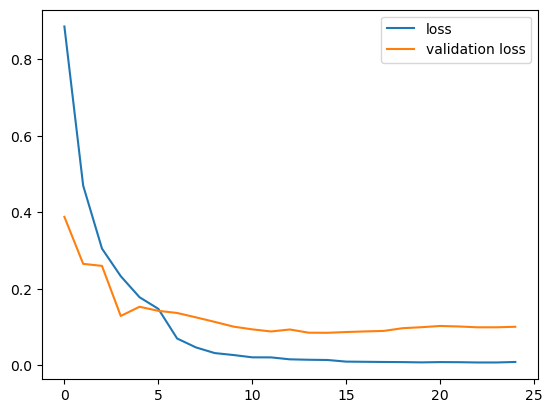

In [36]:
plt.plot(Brain_Tumor_obj.history.history['loss'], label = "loss")
plt.plot(Brain_Tumor_obj.history.history['val_loss'], label = "validation loss")
plt.legend()

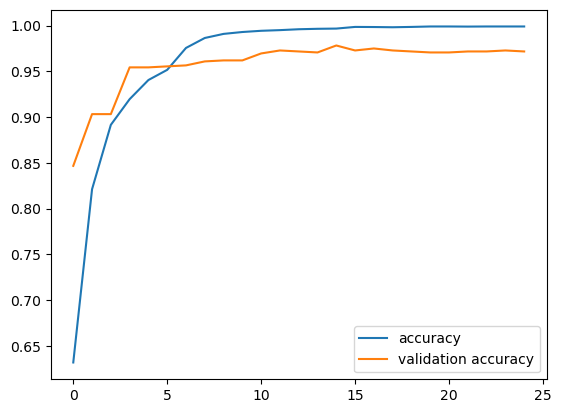

In [37]:
plt.plot(Brain_Tumor_obj.history.history['accuracy'], label = "accuracy")
plt.plot(Brain_Tumor_obj.history.history['val_accuracy'], label = "validation accuracy")
plt.legend()

In [39]:
Brain_Tumor_obj.m.save("brain_tumor_model.h5")
Brain_Tumor_obj.m.save_weights("brain_tumor_weights.h5")

In [40]:
Brain_Tumor_obj.m.evaluate(Brain_Tumor_obj.X_test, 
                           Brain_Tumor_obj.y_test, batch_size = 2)

460/460 [==============================] - 50s 108ms/step - loss: 0.1004 - accuracy: 0.9717


[0.10038895159959793, 0.9717391133308411]

In [41]:
y_pred = Brain_Tumor_obj.m.predict(Brain_Tumor_obj.X_test)

29/29 [==============================] - 44s 1s/step


In [42]:
y_pred = np.argmax(y_pred, axis = 1)

In [43]:
y_test = np.argmax(Brain_Tumor_obj.y_test, axis = 1)

In [44]:
from sklearn.metrics import accuracy_score as ac
ac(y_pred, y_test)

0.9717391304347827

<Axes: >

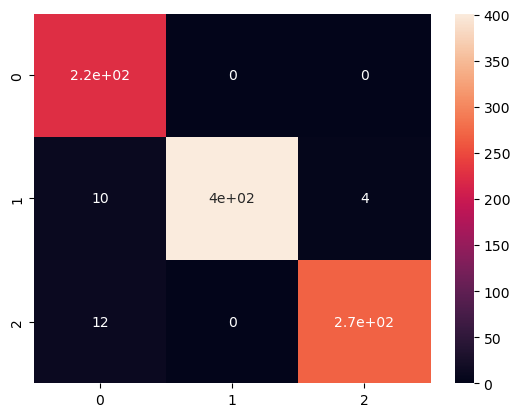

In [45]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(
    y_test,
    y_pred,
), annot=True)

<b>XGBOOST</b>

In [46]:
m = tf.keras.models.load_model("brain_tumor_model.h5")
m.load_weights("brain_tumor_weights.h5")

In [47]:
new_model = tf.keras.models.Model(
    m.input,
    m.get_layer('GlobalAveragePooling2D_').output
)

In [48]:
X_train_features = new_model.predict(Brain_Tumor_obj.X_train)

259/259 [==============================] - 389s 1s/step


In [49]:
X_train_features.shape

(8272, 1024)

In [51]:
!pip install xgboost

     -------------------------------------- 70.9/70.9 MB 335.8 kB/s eta 0:00:00


In [53]:
from xgboost import XGBClassifier

In [54]:
xgb = XGBClassifier(objective='multiclass:softmax', learning_rate = 0.1,
              max_depth = 15, n_estimators = 500)
xgb.fit(X_train_features, np.argmax(Brain_Tumor_obj.y_train, axis = 1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [55]:
X_test_features = new_model.predict(Brain_Tumor_obj.X_test)

29/29 [==============================] - 43s 1s/step


In [56]:
y_pred = xgb.predict(X_test_features)

In [57]:
y_test = np.argmax(Brain_Tumor_obj.y_test, axis =1)

In [58]:
from sklearn.metrics import accuracy_score as ac
ac(y_pred, y_test)

0.9858695652173913

<Axes: >

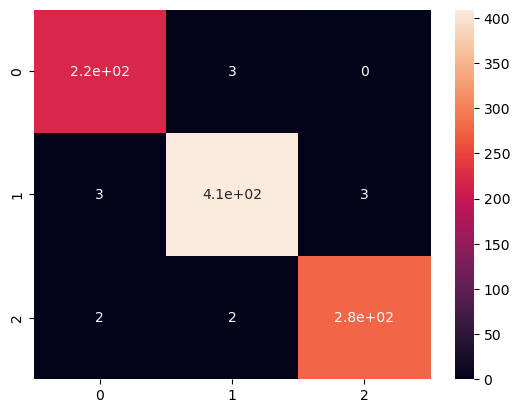

In [59]:
import seaborn as sns
sns.heatmap(tf.math.confusion_matrix(
    y_test,
    y_pred,
), annot=True)